In [1]:
import os
import cv2
import imutils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Crop Images


In [2]:
def crop_images(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if cnts:
        # Find the largest contour
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Add contour and extreme points to the image
        img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 5, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 5, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 5, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 5, (255, 255, 0), -1)

        # Apply crop
        ADD_PIXELS = 0
        new_image = image[
            extTop[1] - ADD_PIXELS : extBot[1] + ADD_PIXELS,
            extLeft[0] - ADD_PIXELS : extRight[0] + ADD_PIXELS,
        ].copy()

        return new_image
    else:
        return None

In [3]:
def crop_and_save_images(input_directory, output_directory):
    plot_shown = False  # Flag to ensure plot is shown only once

    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Crop the image
                cropped_image = crop_images(image)

                if cropped_image is not None:
                    # Save the cropped image
                    class_name = os.path.basename(os.path.dirname(image_path))
                    class_directory = os.path.join(output_directory, class_name)
                    os.makedirs(class_directory, exist_ok=True)
                    new_image_path = os.path.join(class_directory, file)
                    cv2.imwrite(new_image_path, cropped_image)

                    if not plot_shown:
                        # Plot the sequential steps only if not shown before
                        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                        axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                        axs[0].set_title("Original Image")
                        axs[0].axis("off")

                        axs[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
                        axs[1].set_title("Cropped Image")
                        axs[1].axis("off")

                        plt.tight_layout()
                        plt.show()
                        plot_shown = True

## Augmented Data


In [4]:
def augment_images(
    input_directory, output_directory, num_images=5, num_images_no_tumor=10
):

    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        rescale=1.0 / 255,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.1, 1.5],
        horizontal_flip=True,
    )

    datagen_no_tumor = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        rescale=1.0 / 255,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.1, 1.5],
        horizontal_flip=True,
    )

    for root, dirs, files in os.walk(input_directory):

        for file in files:

            if file.endswith(".jpg") or file.endswith(".png"):

                image_path = os.path.join(root, file)

                image = cv2.imread(image_path)

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                image = image.reshape((1,) + image.shape)

                save_prefix = file.split(".")[0] + "_aug"

                class_name = os.path.basename(os.path.dirname(image_path))

                data_split = os.path.basename(
                    os.path.dirname(os.path.dirname(image_path))
                )

                class_directory = os.path.join(output_directory, data_split, class_name)

                os.makedirs(class_directory, exist_ok=True)

                if class_name == "no_tumor":

                    i = 0

                    for batch in datagen_no_tumor.flow(
                        image,
                        batch_size=1,
                        save_to_dir=class_directory,
                        save_prefix=save_prefix,
                        save_format="jpg",
                    ):

                        i += 1

                        if i >= num_images_no_tumor:

                            break

                else:

                    i = 0

                    for batch in datagen.flow(
                        image,
                        batch_size=1,
                        save_to_dir=class_directory,
                        save_prefix=save_prefix,
                        save_format="jpg",
                    ):

                        i += 1

                        if i >= num_images:

                            break

## Crop Data Without Augmentation


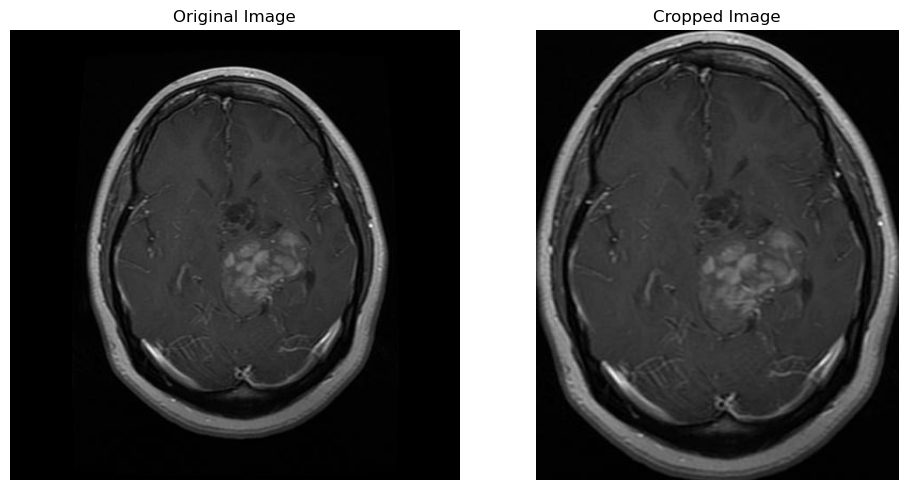

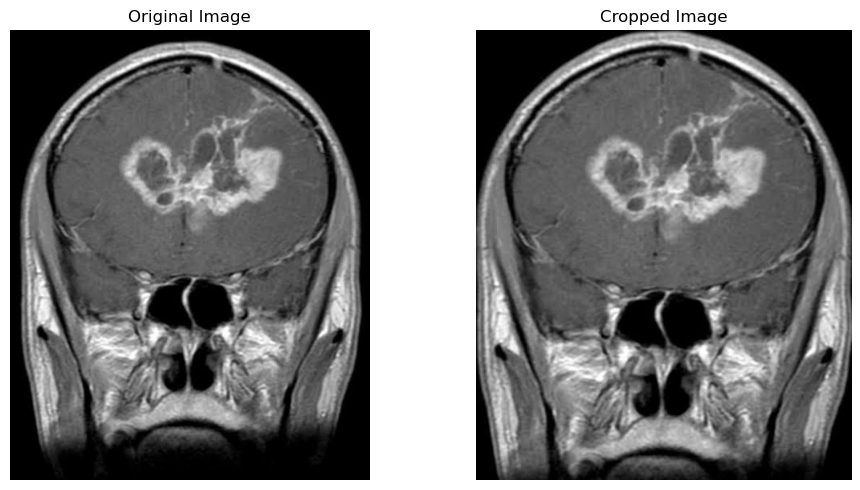

In [5]:
cropped_train = "./Brain Tumor/Training"
cropped_test = "./Brain Tumor/Testing"

cropped_train_directory = "./Images_Cropped_No_Augmentation/cropped_training"
os.makedirs(cropped_train_directory, exist_ok=True)
crop_and_save_images(cropped_train, cropped_train_directory)

cropped_test_directory = "./Images_Cropped_No_Augmentation/cropped_testing/"
os.makedirs(cropped_test_directory, exist_ok=True)
crop_and_save_images(cropped_test, cropped_test_directory)

## Augmentaion


In [6]:
augmented_directory = "./augmented_data"
train_directory = "./Brain Tumor/Training"
test_directory = "./Brain Tumor/Testing"
augment_images(train_directory, augmented_directory)
augment_images(test_directory, augmented_directory)

## Crop Augmentaion Data


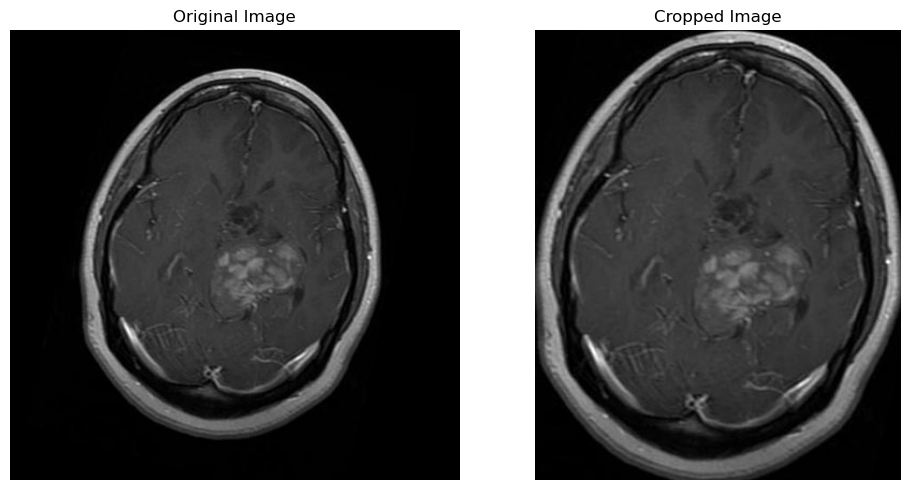

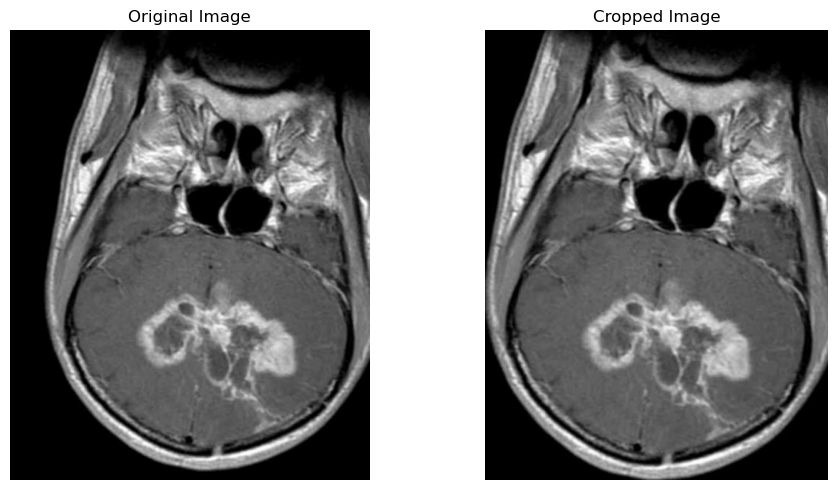

In [7]:
cropped_train = "./augmented_data/Training"
cropped_test = "./augmented_data/Testing"

cropped_train_directory = "./Images_Cropped_With_Augmentation/cropped_training/"
os.makedirs(cropped_train_directory, exist_ok=True)
crop_and_save_images(cropped_train, cropped_train_directory)

cropped_test_directory = "./Images_Cropped_With_Augmentation/cropped_testing/"
os.makedirs(cropped_test_directory, exist_ok=True)
crop_and_save_images(cropped_test, cropped_test_directory)

## Brain Data with Crop and Augmentation


In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import pandas as pd

In [2]:
CLASSES = {
    "no_tumor": 0,
    "pituitary_tumor": 1,
    "glioma_tumor": 2,
    "meningioma_tumor": 3,
}

In [3]:
def load_data_from_directory(directory_path):
    X = []
    Y = []

    for class_name, label in CLASSES.items():
        class_path = os.path.join(directory_path, class_name)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            img = cv2.imread(image_path, 0)
            img = cv2.resize(img, (224, 224))
            img_flat = img.flatten() / 255.0
            X.append(img_flat)
            Y.append(label)

    return np.array(X), np.array(Y)

In [4]:
training_directory = "./Images_Cropped_With_Augmentation/cropped_training"
testing_directory = "./Images_Cropped_With_Augmentation/cropped_testing"

In [5]:
X_train, Y_train = load_data_from_directory(training_directory)
X_test, Y_test = load_data_from_directory(testing_directory)

In [6]:
# SVC with PCA
pca = PCA(n_components=0.98)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

svc = SVC()
svc.fit(pca_train, Y_train)
train_score = svc.score(pca_train, Y_train)
print("Training Score:", train_score)
test_score = svc.score(pca_test, Y_test)
print("Testing Score:", test_score)

Training Score: 0.9214040676304828
Testing Score: 0.5643286573146292


In [7]:
train_predictions = svc.predict(pca_train)
print(train_predictions)

test_predictions = svc.predict(pca_test)
print(test_predictions)

[0 0 0 ... 3 3 3]
[0 0 0 ... 0 0 3]


In [8]:
train_accuracy = accuracy_score(Y_train, train_predictions)
print("Training Accuracy:", train_accuracy)

test_accuracy = accuracy_score(Y_test, test_predictions)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9214040676304828
Testing Accuracy: 0.5643286573146292


In [11]:
train_precision = precision_score(Y_train, train_predictions, average="micro")
print("Training Precision:", train_precision)

test_precision = precision_score(Y_test, test_predictions, average="micro")
print("Testing Precision:", test_precision)

Training Precision: 0.9214040676304828
Testing Precision: 0.5643286573146292


In [13]:
train_recall = recall_score(Y_train, train_predictions, average="micro")
print("Training Recall:", train_recall)

test_recall = recall_score(Y_test, test_predictions, average="micro")
print("Testing Recall:", test_recall)

Training Recall: 0.9214040676304828
Testing Recall: 0.5643286573146292


In [15]:
train_f1 = f1_score(Y_train, train_predictions, average="micro")
print("Training F1 Score:", train_f1)

test_f1 = f1_score(Y_test, test_predictions, average="micro")
print("Testing F1 Score:", test_f1)

Training F1 Score: 0.9214040676304828
Testing F1 Score: 0.5643286573146292


In [16]:
train_conf_matrix = confusion_matrix(Y_train, train_predictions)
test_conf_matrix = confusion_matrix(Y_test, test_predictions)

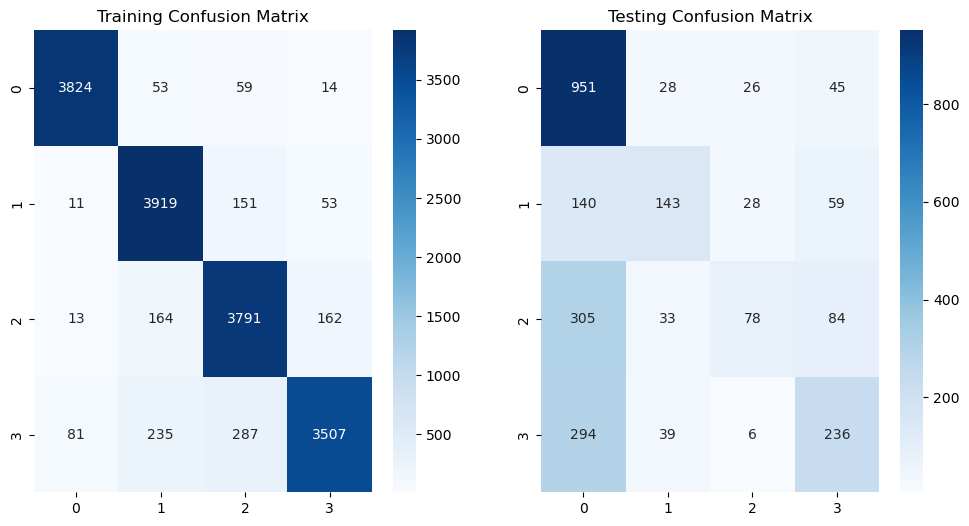

In [17]:
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, cmap="Blues", fmt="g")
plt.title("Training Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, cmap="Blues", fmt="g")
plt.title("Testing Confusion Matrix")

plt.show()

In [7]:
training_directory = "./Images_Cropped_With_Augmentation/cropped_training"

X_train, Y_train = load_data_from_directory(training_directory)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

# SVC with PCA


pca = PCA(n_components=0.98)


pca_train = pca.fit_transform(X_train)


pca_test = pca.transform(X_test)



svc0 = SVC()


svc0.fit(pca_train, Y_train)



train_score0 = svc0.score(pca_train, Y_train)



print("Training Score:", train_score0)


test_score0 = svc0.score(pca_test, Y_test)



print("Testing Score:", test_score0)

Training Score: 0.9154606018837583
Testing Score: 0.757427258805513


In [20]:
# Display sample images and predictions
def display_samples(folder, title, num_samples=9):
    plt.figure(figsize=(12, 8))
    c = 1
    for i, filename in enumerate(os.listdir(folder)[:num_samples]):
        img = cv2.imread(os.path.join(folder, filename), 0)
        img = cv2.resize(img, (224, 224)).flatten() / 255.0
        prediction = svc.predict(pca.transform([img]))

        plt.subplot(3, 3, c)
        plt.title(dec[prediction[0]])
        plt.imshow(img.reshape(224, 224), cmap="gray")
        plt.axis("off")
        c += 1
    plt.suptitle(title)
    plt.show()

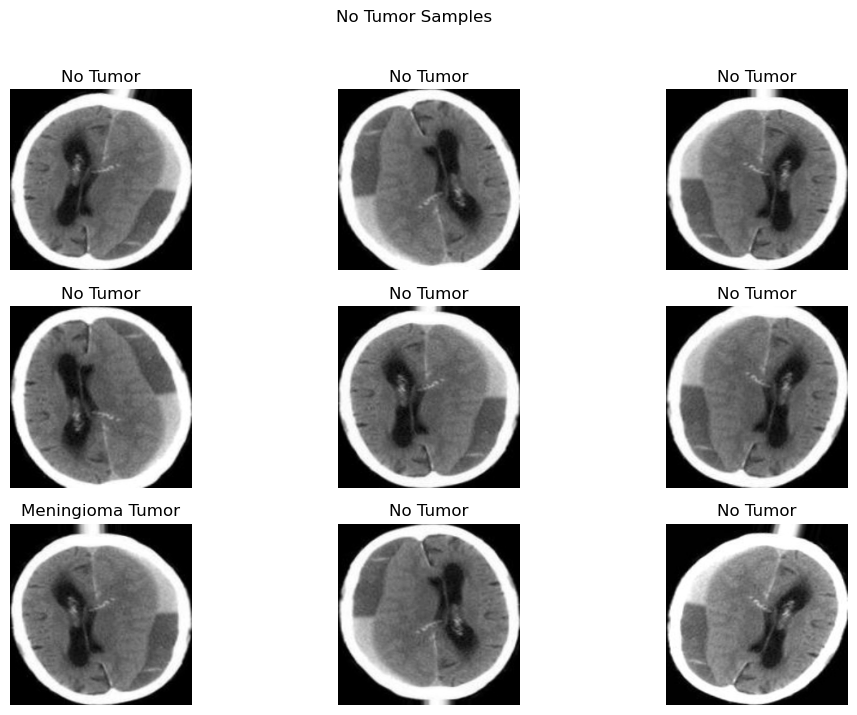

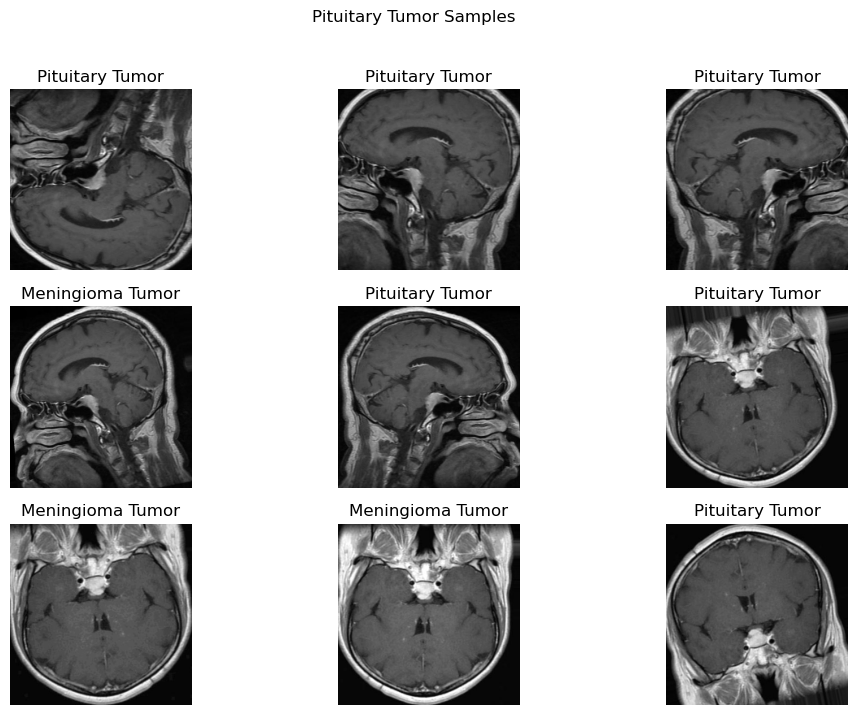

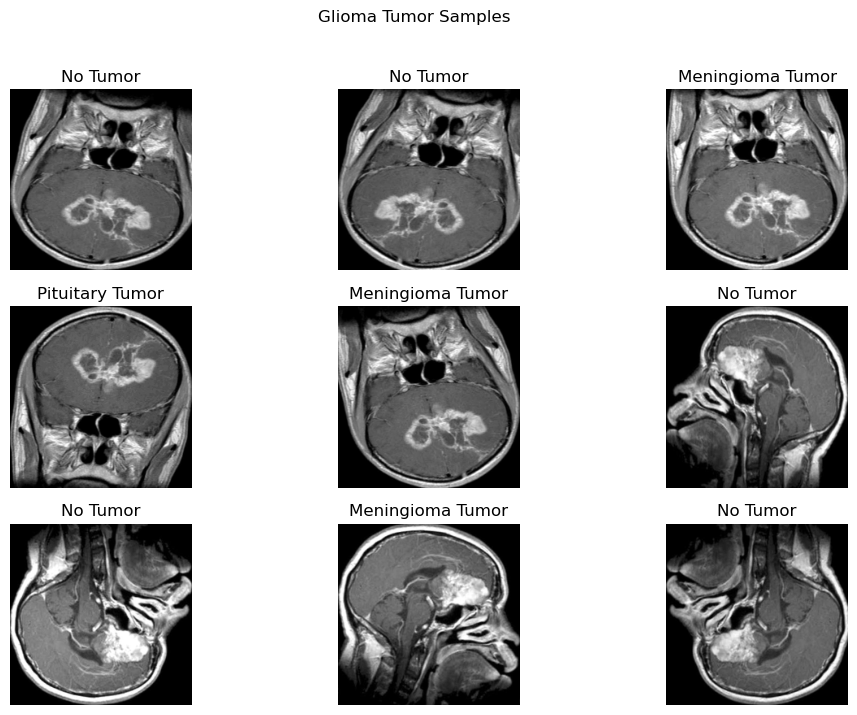

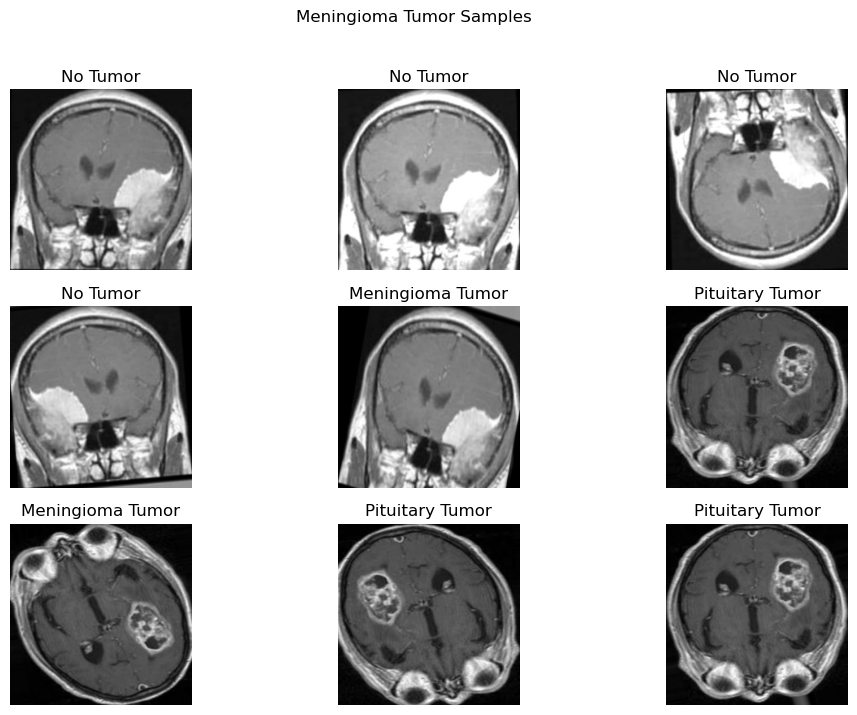

In [21]:
dec = {0: "No Tumor", 1: "Pituitary Tumor", 2: "Glioma Tumor", 3: "Meningioma Tumor"}
tumor_folders = ["no_tumor", "pituitary_tumor", "glioma_tumor", "meningioma_tumor"]
for tumor_folder in tumor_folders:
    folder_path = f"Images_Cropped_With_Augmentation\\cropped_testing\\{tumor_folder}\\"
    title = f'{tumor_folder.replace("_", " ").title()} Samples'
    display_samples(folder_path, title)

In [22]:
tumor_counts = {dec[label]: np.sum(Y_train == label) for label in CLASSES.values()}
table_data = {
    "Index": range(1, len(CLASSES) + 1),
    "Tumor Type": list(tumor_counts.keys()),
    "Count": list(tumor_counts.values()),
}
tumor_table = pd.DataFrame(table_data)
styled_table = tumor_table.style.set_properties(
    **{"border": "3px solid black", "text-align": "center"}
)
print("\033[1mTumor Type Counts:\033[0m")
display(styled_table)

Tumor Type Counts:


,Index,Tumor Type,Count
0,1,No Tumor,3950
1,2,Pituitary Tumor,4134
2,3,Glioma Tumor,4130
3,4,Meningioma Tumor,4110


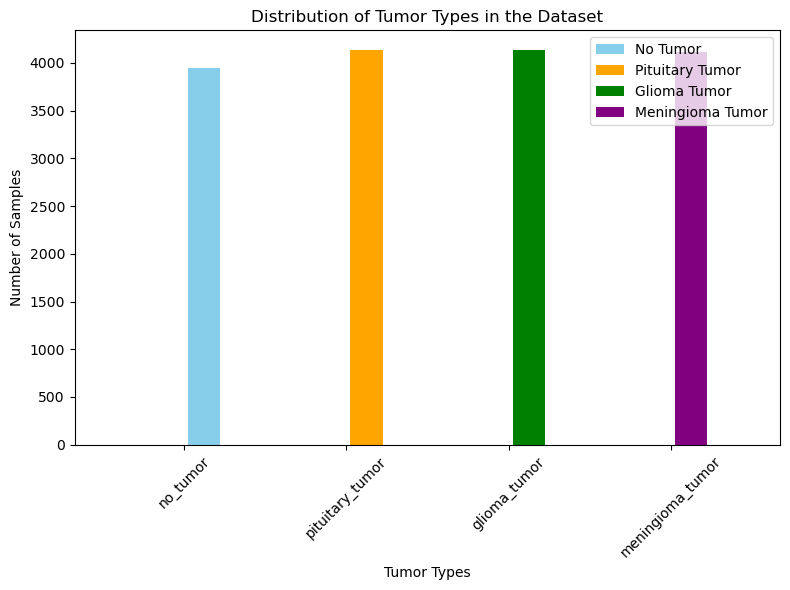

In [23]:
tumor_labels = [dec[label] for label in Y_train]
colors = ["skyblue", "orange", "green", "purple"]
plt.figure(figsize=(8, 6))
for label, color in zip(CLASSES.values(), colors):
    plt.hist(
        np.array(tumor_labels)[Y_train == label],
        bins=len(CLASSES),
        align="mid",
        rwidth=0.8,
        color=color,
        label=dec[label],
    )
plt.xlabel("Tumor Types")
plt.ylabel("Number of Samples")
plt.title("Distribution of Tumor Types in the Dataset")
plt.xticks(range(len(CLASSES)), list(CLASSES.keys()), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()